In [1]:
import datetime
import pyaurorax
import cartopy.crs
import pprint

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Create TREx Spectrograph mosaic

Generating Spectrograph mosaics is very similar to making them for all-sky imagers like THEMIS, REGO, and TREx RGB. However, the spectrograph has a different field of view that its data covers. Where an all-sky imager has a circular FoV (due to the fisheye lens and all-sky nature of the data), the spectrograph's FoV is a straight line, oriented towards magnetic north.

The most common use case of mosaics for the spectrographs is overlaying them on top of ASI data, like TREx RGB. Below, we'll work through an example of that.

## Step 1: Download and read image data

For this example, we're going to make a mosaic of several TREx RGBs and both TREx Spectrograph plotted on top. First step is to download and read in the image data for both those instruments.

NOTE: TREx Spectrograph data is organized into 1-hr files, where-as the ASI data is in 1 minute files. That will be why the data files are so much larger compared to the ASIs.

In [2]:
# download and read a minute of RGB data from several sites
start_dt = datetime.datetime(2021, 3, 13, 9, 40, 15)
end_dt = start_dt
rgb_site_list = ["gill", "rabb", "luck"]
data_list = []
for site_uid in rgb_site_list:
    r = aurorax.data.ucalgary.download("TREX_RGB_RAW_NOMINAL", start_dt, end_dt, site_uid=site_uid)
    data = aurorax.data.ucalgary.read(r.dataset, r.filenames)
    data_list.append(data)

# download TREx Spectrograph data from both sites for the same time
#
# NOTE: since the TREx Spectrograph files are 1-hr files, but we're only currently interested in a single
# timestamp, we'll use the start_time and end_time parameters to only read in the specific timestamp we want
spect_site_list = ["rabb", "luck"]
for site_uid in spect_site_list:
    r = aurorax.data.ucalgary.download("TREX_SPECT_PROCESSED_V1", start_dt, end_dt, site_uid=site_uid)
    data = aurorax.data.ucalgary.read(r.dataset, r.filenames, start_time=start_dt, end_time=end_dt)
    data_list.append(data)

## Step 2: Download and read skymaps

Next up, we'll download and read the skymap data for both the TREx RGBs and the TREx Spectrographs.

Remember, if you aren't sure about the dataset names to use, you can use the `aurorax.data.list_datasets()` function or navigate to a specific instrument's [Dataset Documentation](https://data.phys.ucalgary.ca/about_datasets/index.html) page.

In [3]:
# download and read the TREx RGB skymaps
skymaps = []
for site_uid in rgb_site_list:
    r = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap_data = aurorax.data.ucalgary.read(r.dataset, r.filenames)
    skymaps.append(skymap_data.data[0])

# download and read the TREx Spectrograph skymaps
for site_uid in spect_site_list:
    r = aurorax.data.ucalgary.download_best_skymap("TREX_SPECT_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap_data = aurorax.data.ucalgary.read(r.dataset, r.filenames)
    skymaps.append(skymap_data.data[0])

pprint.pprint(skymaps)

[Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=spect, site_uid=rabb, imager_uid=spect-01, site_map_latitude=58.227810, site_map_longitude=-103.680634, ...),
 Skymap(project_uid=spect, site_uid=luck, imager_uid=spect-02, site_map_latitude=51.153988, site_map_longitude=-107.264732, ...)]


## Step 3: Prepare the skymap and image data

In [4]:
# prepare the skymap data
#
# NOTE: this step is not time dependent, so it only needs to be performed once
# per set of skymaps.
prepped_skymaps = at.mosaic.prep_skymaps(skymaps, 110, n_parallel=5)
print(prepped_skymaps)

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 265440),(5, 256), dtype=float64), polyfill_lon=array(dims=(5, 265440),(5, 256), dtype=float64), elevation=array(dims=(265440,),(256,), dtype=float32), site_uid_list=['gill', 'rabb', 'luck', 'rabb', 'luck'])


In [5]:
# Prepare the image data

# For spectrograph data, we need to pick what emission to prepare intensity values for. This is done
# by integrating the spectrum. Common defaults can be selected such as the greenline (557.7 nm) or
# redline (630.0 nm), etc. emissions. You can also manually define wavelengths to integrate between
# to get emissions of interest, using the 'spect_band' and 'spect_band_bg' keywords.

# Let's first look at the greenline emission (this is the default if no emission is supplied)
prepped_images = at.mosaic.prep_images(data_list, spect_emission="green")
prepped_images

MosaicData(images=Dict[5 sites of array(dims=(480, 553),(256, 20))], timestamps=[20 timestamps], site_uid_list=['gill', 'rabb', 'luck', 'rabb_spect', 'luck_spect'])

## Step 4: Generate the mosaic

In [6]:
# define the intensity scales for each ASI site
#
# NOTE: you can define intensity scale for each site separately, all sites as a whole, or not at all
scale = {
    "gill": (10, 105),
    "rabb": (10, 105),
    "luck": (10, 105),
}

# Now, we will also define the scaling bounds for the spectrograph data.
# Let's scale between 0 to 7.5 kR
spect_rayleighs_scale = (0, 7500)

# Set timestamp to actually create mosaic frame for
mosaic_dt = datetime.datetime(2021, 3, 13, 9, 40, 15)

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images,
                          prepped_skymaps,
                          mosaic_dt,
                          projection_obj,
                          image_intensity_scales=scale,
                          spect_intensity_scales=spect_rayleighs_scale)

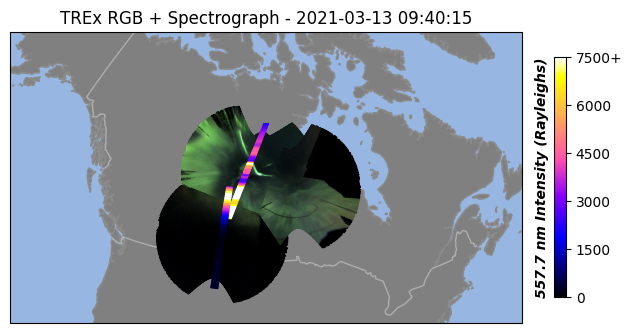

In [7]:
# plot mosaic
map_extent = [-135, -65, 35, 70]
mosaic.plot(map_extent,
            title="TREx RGB + Spectrograph - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")),
            colorbar_title="557.7 nm Intensity (Rayleighs)")

As a sanity check, the 555.7 nm intensity is indeed higher in regions that overlap with the green aurora in TREx RGB, as expected.

# Viewing other emissions



In [8]:
# re-prep our data, this time, for the blueline emission
prepped_images = at.mosaic.prep_images(data_list, spect_emission="blue")

In [9]:
# The blueline emission is lower intensity than the greenline,
# so let's scale down a bit.
spect_rayleighs_scale = [0, 1500]

# Create our new mosaic... let's pick a blue colormap for the blueline
mosaic = at.mosaic.create(prepped_images,
                          prepped_skymaps,
                          mosaic_dt,
                          projection_obj,
                          image_intensity_scales=scale,
                          spect_intensity_scales=spect_rayleighs_scale,
                          spect_colormap="Blues_r")

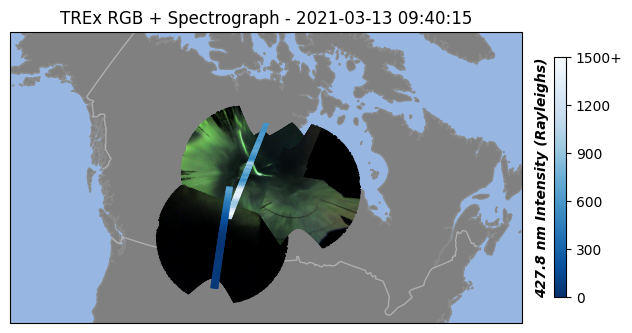

In [10]:
mosaic.plot(map_extent,
            title="TREx RGB + Spectrograph - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")),
            colorbar_title="427.8 nm Intensity (Rayleighs)",
            cbar_colormap="Blues_r")